# Near Eclipsing Binary diagnostic

In the case of a TESS follow-up observation, when the expected transit does not appear in the target light curve, a possibility is that the transit signal actually originates from a nearby star. We will then explore the field close to the target to search for a near eclipsing binary or a transit on a nearby star. 

## Reducing the data
The first step is to do the image calibration as explained *here* (link to doc) and obtain a `.phot` file in which all the data and information about the observation is stored.

In [ ]:
from prose import FitsManager 
from prose.pipeline import Calibration 
from prose import load 

# exploring folder
fm = FitsManager("/Users/lionelgarcia/Downloads/Artemis_20200817_TOI-2084-01_I+z_raw_data/20200817")

# running the calibration
calibration = Calibration(**fm.images_dict)
calibration.run(fm.obs_name)

# loading the products
obs = load(calibration.phot_path) # Not including photometry yet

## Selecting the stars for the photometry 
As with any other observation, our fist step consists in detecting stars in the field, here using `DAOFindStars`

<Figure size 432x288 with 0 Axes>

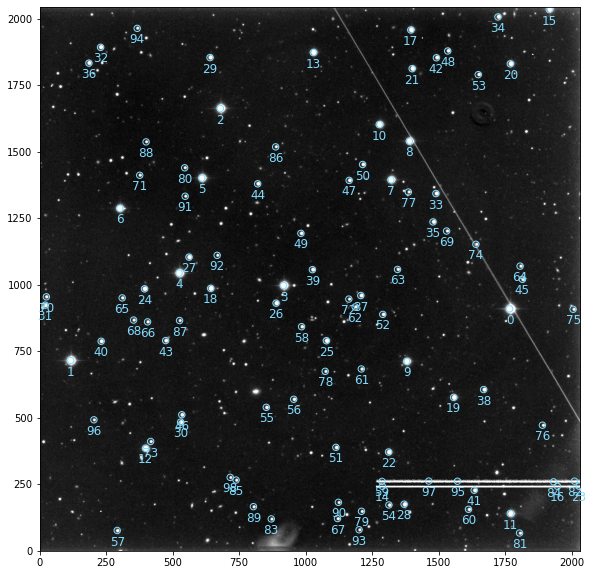

In [3]:
from prose import blocks

base_stars, _ = blocks.DAOFindStars(n_stars=100, min_separation=10)(obs.stack)
obs.show_stars(stars=base_stars)

In the context of TESS follow-up observations, the stars to check around the target are provided in the form of a file containing their RA/DEC coordinates. We will then replace the stars around our target with these ones.

In [7]:
import numpy as np
import pandas as pd 
from astropy import units as u

# Loading some ra-dec from a file 
radecs = pd.read_csv("gaia_stars_1622574347.radec", names=["ra", "dec"], usecols=[0, 1]).iloc[:, [0, 1]].values
close_stars = obs.radec_to_pixel(radecs, unit=(u.hourangle, u.deg))

# We only keep detected stars outside a 2.5 arcmin radius circle centered on target (indexed 0 in radecs) ...
target_distance = np.linalg.norm(base_stars - close_stars[0], axis=1)
base_stars = base_stars[np.argwhere(target_distance * obs.telescope.pixel_scale / 60 > 2.6).flatten() ]

# ... and add the stars based on the loaded radecs
full_stars = np.vstack([close_stars, base_stars])

We end up with a set of stars containing all visible stars in the field, plus close-by stars (some too faint to be detected, so added from a RA-DEC catalogue). Let's plot that:

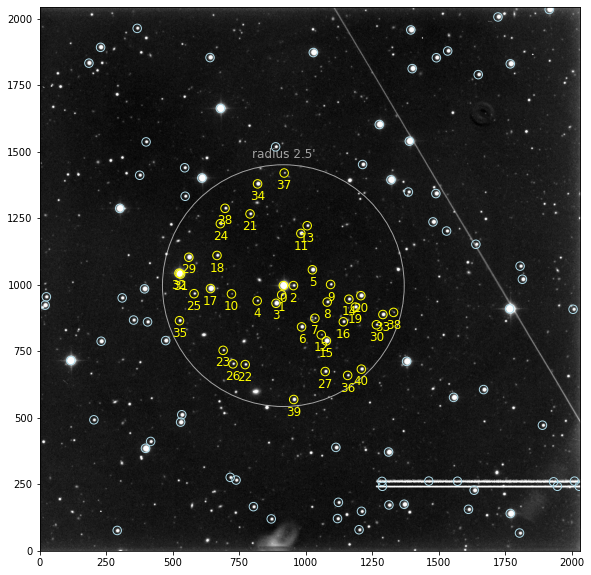

In [8]:
from matplotlib import pyplot as plt
from prose import viz

obs.show()
obs.plot_circle(close_stars[0], arcmin=2.5) # a 2.5 arcmon circle around the target (id=0 here)
viz.plot_marks(*base_stars.T, color='lightblue', ms=16)
viz.plot_marks(*close_stars.T, color='yellow', ms=16, label=True)

## Photometry
We can now start the aperture photometry with the stars we have found above. 

In [9]:
from prose.pipeline import AperturePhotometry

photometry = AperturePhotometry(calibration.images, calibration.stack, stars=full_stars)
photometry.run(calibration.phot_path)

INFO detected stars: 118
INFO global psf FWHM: 4.75 (pixels)


RUN Photometry: 100%|█████████████████████| 756/756 [11:30<00:00,  1.09images/s]


and load the corresponding `.phot` file to perform differential photometry on

<Figure size 432x288 with 0 Axes>

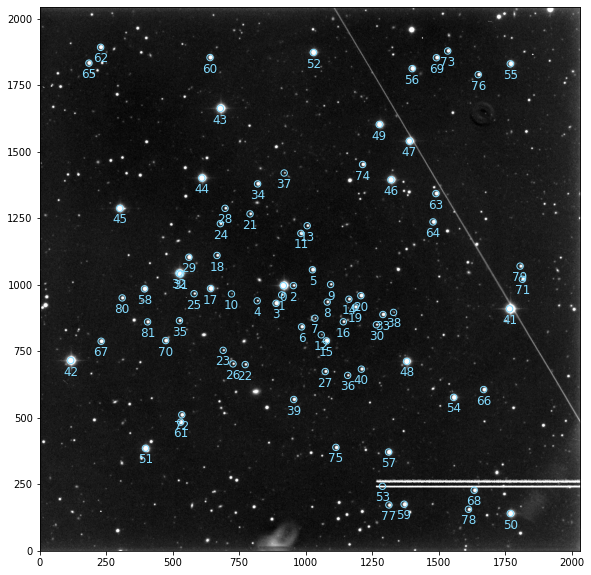

In [12]:
obs = load(photometry.phot_path)

# we keep the best stars as well as the ones added from catalogue
obs.keep_good_stars(keep=len(radecs), trim=100)
obs.show_stars()

(0.98, 1.02)

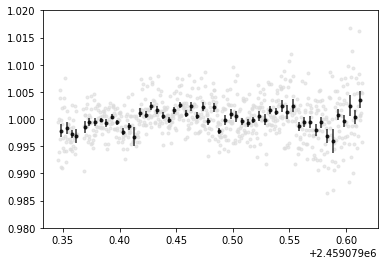

In [13]:
from matplotlib import pyplot as plt

obs.target = 0
obs.broeg2005()
obs.plot()
plt.ylim(0.98,1.02)

## NEB check 

Let us define first the parameters of our expected transit :

In [14]:
epoch = 2458745.410754 # obs.time unit (here bjd-tdb) 
period = 8.149028 # days
duration = 2.321055/24 # days
depth = 2.851  # ppt
t0 = 2459079.5209 # epoch unit

We start by creating an object of the class NEB by specifying the radius within which we want to check the stars. Then we use the `NEB.evaluate_score` function to calculate the predicted transits for each star following the method of AstroImageJ, and the disposition of each star (cleared, likely cleared or not cleared)

In [15]:
from prose.diagnostics.near_eclipsing_binary import NEB

neb = NEB(obs,radius=2.5)
neb.evaluate_score(epoch, duration, depth, period)

We can then plot the light curves of stars deemed as suspect using the `NEB.plot_suspects` function

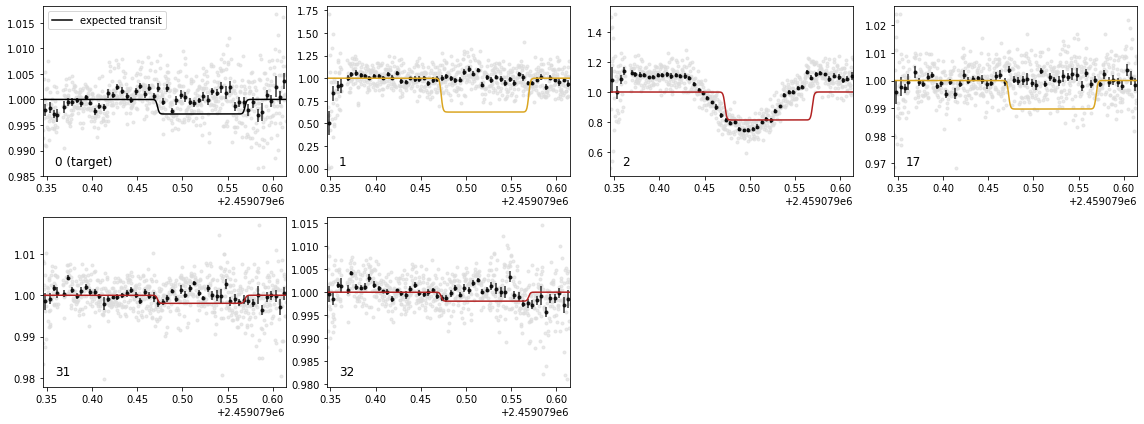

In [16]:
neb.plot_suspects()

and identify them on the stack image

<Figure size 432x288 with 0 Axes>

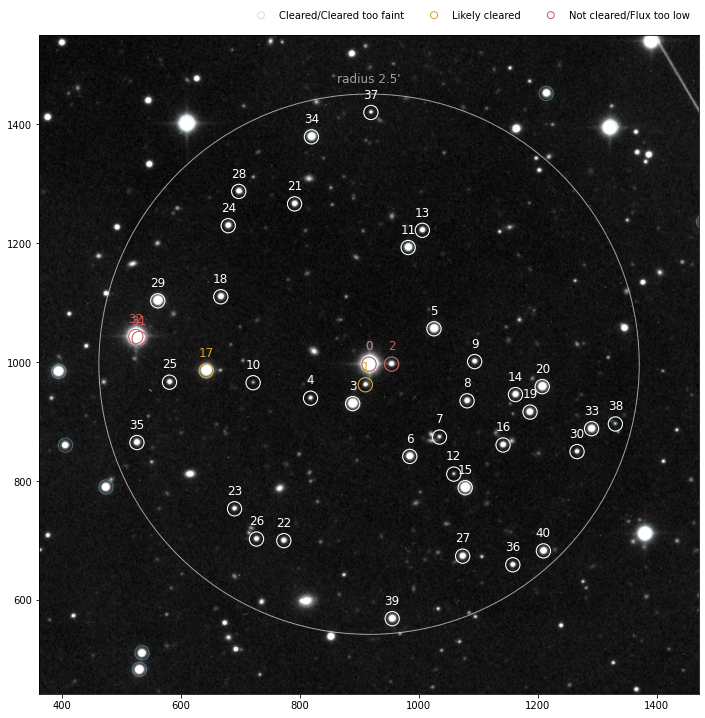

In [17]:
neb.show_neb_stars()

We have found the star guilty of the transit-like feature in the TESS data ! It is labelled 2 on the stack image. 

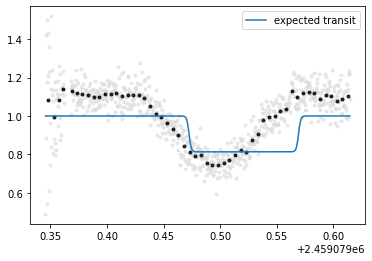

In [18]:
neb.plot(2)

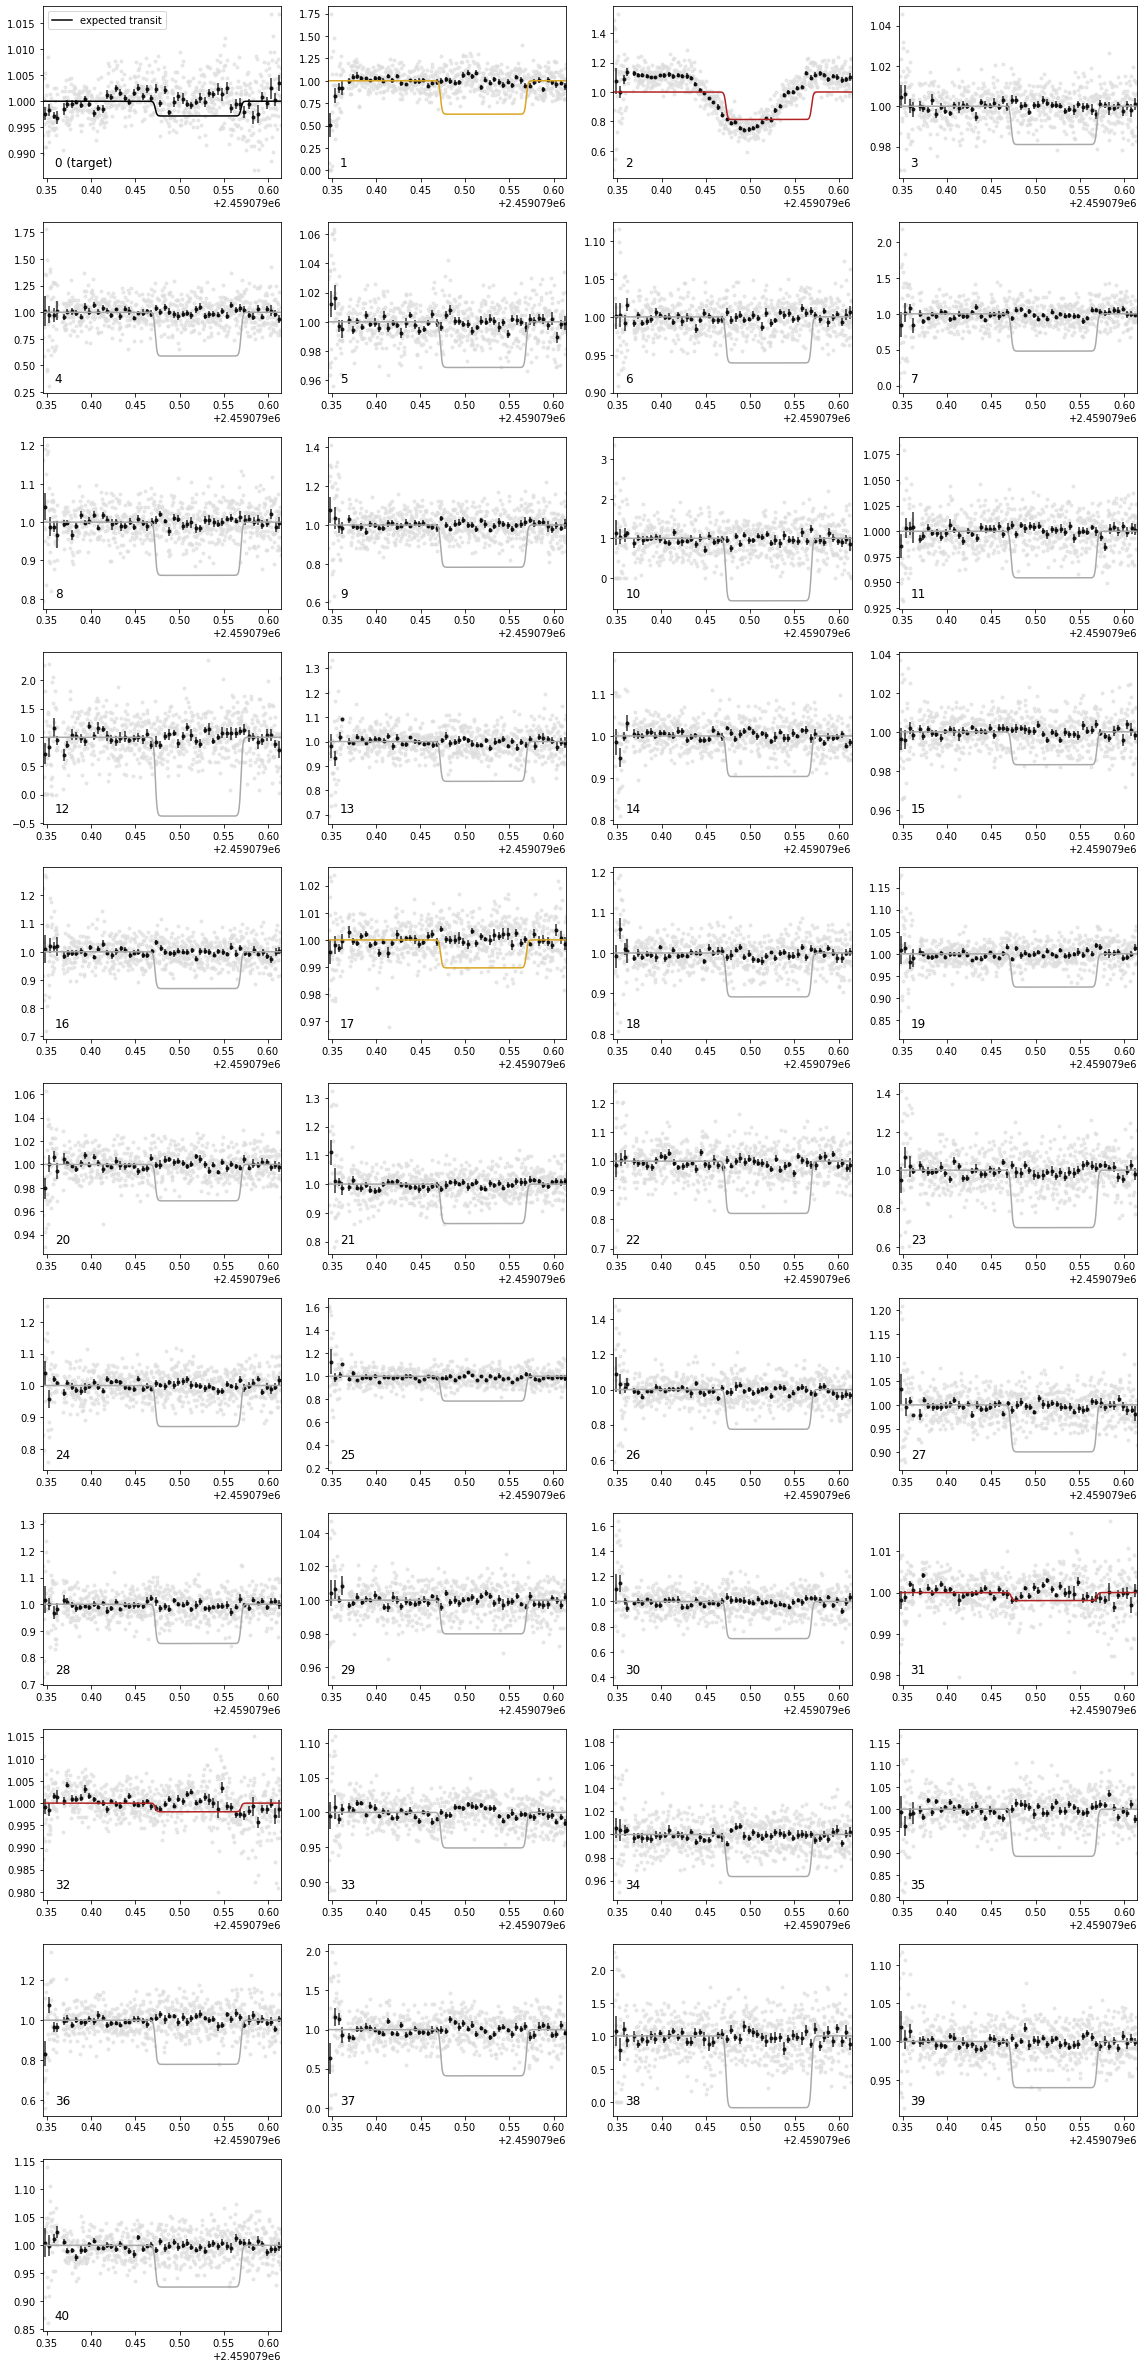

In [8]:
#To check all light curves
neb.plot_lcs(idxs=neb.nearby_ids)

## Report
We will probably want to share our discovery with the rest of the community, this is easily done using the prose reports, we only need to add a dedicated page to the basic report.  

In [19]:
from prose.reports import Report, Summary, TESSSummary, NEBCheck

# The latex pages
summary = TESSSummary(obs, expected=(t0, duration))
nebcheck = NEBCheck(neb)

# Make the full report
report = Report([summary,nebcheck])
report.make(f"{obs.denominator}_report")

making summary ...
making neb ...


<Figure size 432x288 with 0 Axes>

In [9]:
report.compile()

## Tfop specific outputs

By default only the suspect light curves are plotted for the report with images of 6x4 for the first 24 suspects and 6x6 for the rest, and all the figures have transparent background for a nicer finish. You can save the plots the light curves of all the images using the neb_plot_lcs() function, the report_layout argument is symbolizing whether we want the 6x4 and 6x6 images (True, default) or not (False). You can also re-save all the figures with a non transparent background using the make_figure() function, and the disposition 'both' means you will get a folder with all the light curves and one with just the suspects. 

In [ ]:
nebcheck.make_figures(destination='Artemis_20200817_TOI-2084-01_I+z_report/neb/figures',transparent=False,disposition='both',report_layout=False)

Finally, to prepare the report, the figures must follow a dedicated nomenclature. You can use the function copy_figures() to rename them. 

In [ ]:
obs.tfop_prefix

In [ ]:
from prose.reports.core import copy_figurescopy_figures(folder='Artemis_20200817_TOI-2084-01_I+z_report',prefix='TIC441738827-01_20200817_Artemis_I+z',destination='Artemis_20200817_TOI-2084-01_I+z_report/figures')